In [ ]:
!pip install scikit-learn seaborn openmeteo_requests requests_cache retry_requests retry_requests pymysql -U pandas numpy


In [49]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


In [50]:
!python final.py

   com.samsung.health.exercise.start_time com.samsung.health.exercise.end_time
51                2022-11-26 09:44:58.977              2022-11-26 09:49:23.347
52                2022-11-26 09:49:31.204              2022-11-26 10:01:31.002
53                2022-11-26 10:10:11.597              2022-11-26 10:13:30.904
86                2023-02-04 09:53:04.770              2023-02-04 09:53:57.536
87                2023-02-04 09:54:31.056              2023-02-04 10:04:53.564
            start_time  ... hours_adjusted
13 2022-11-26 09:49:23  ...           True
14 2022-11-26 10:01:31  ...           True
15 2022-11-26 10:13:30  ...           True
43 2023-02-04 09:53:57  ...           True
44 2023-02-04 10:04:53  ...           True
45 2023-02-04 12:55:40  ...           True
51 2023-02-11 10:23:03  ...           True
52 2023-02-11 10:37:29  ...           True
60 2023-02-24 08:56:37  ...           True
65 2023-03-07 08:42:02  ...           True

[10 rows x 4 columns]
✅ Dados salvos com sucesso no 

c:\Users\10142578\Downloads\PedroHenriqueAlmeidaTCC-main\PedroHenriqueAlmeidaTCC-main\final.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_running_metrics['temperature_2m'] = None
c:\Users\10142578\Downloads\PedroHenriqueAlmeidaTCC-main\PedroHenriqueAlmeidaTCC-main\final.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_running_metrics['relative_humidity_2m'] = None
c:\Users\10142578\Downloads\PedroHenriqueAlmeidaTCC-main\PedroHenriqueAlmeidaTCC-main\final.py:117: SettingWithCopyWarning: 
A

In [51]:
import pandas as pd

# 🚫 Sem banco de dados — vamos ler direto do CSV salvo anteriormente
input_file = 'novosDadosTeste.csv'   # arquivo gerado no seu script final.py

# Lendo os dados do CSV
df = pd.read_csv(input_file)

# Salvando no novo arquivo de saída
output_file = 'dados_treinamento.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"✅ Dados exportados com sucesso para o arquivo: {output_file}")

✅ Dados exportados com sucesso para o arquivo: dados_treinamento.csv


In [52]:
df = pd.read_csv('dados_treinamento.csv')
print(df.head())

  total_calorie  heart_rate_sample_count location_data_internal  \
0     3.932.612                    170.0                    NaN   
1    15.104.414                    684.0                    NaN   
2    28.215.462                    170.0                    NaN   
3     8.710.767                     25.0                    NaN   
4     1.274.539                    592.0                    NaN   

   com.samsung.health.exercise.duration  \
0                                183807   
1                                715384   
2                                187302   
3                                 48789   
4                                613389   

  com.samsung.health.exercise.start_time  \
0                2022-11-26 09:44:58.977   
1                2022-11-26 09:49:31.204   
2                2022-11-26 10:10:11.597   
3                2023-02-04 09:53:04.770   
4                2023-02-04 09:54:31.056   

   com.samsung.health.exercise.mean_heart_rate  \
0                      

In [53]:
df_to_prepare = df[['com.samsung.health.exercise.distance', 
                    'com.samsung.health.exercise.mean_speed',
                    'com.samsung.health.exercise.duration', 'com.samsung.health.exercise.mean_heart_rate',
                    'sleep_duration', 
                    'temperature_2m', 'relative_humidity_2m', 'sleep_score', 'mental_recovery', 
                    ]]

#Posso colocar o 'sleep_duration' e retirar max_heart_rate e vo2_max
#'com.samsung.health.exercise.calorie'
#'physical_recovery'

print(df_to_prepare.head())

  com.samsung.health.exercise.distance com.samsung.health.exercise.mean_speed  \
0                              385.054                              2.094.882   
1                            1.812.617                              2.533.768   
2                              357.093                             19.065.092   
3                               99.515                             20.397.015   
4                              1554.75                             25.346.885   

   com.samsung.health.exercise.duration  \
0                                183807   
1                                715384   
2                                187302   
3                                 48789   
4                                613389   

   com.samsung.health.exercise.mean_heart_rate             sleep_duration  \
0                                        140.0  0 days 00:00:00.000000449   
1                                        171.0  0 days 00:00:00.000000449   
2                      

In [55]:
import re
import pandas as pd

def limpar_valor(v):
    if isinstance(v, str):
        # Extrai o primeiro número (inteiro ou decimal, incluindo negativos)
        numeros = re.findall(r"[-+]?\d*\.\d+|\d+", v)
        if numeros:
            return float(numeros[0])
        else:
            return None
    return v

# Aplica a função somente nas colunas problemáticas
colunas_com_texto = [
    'com.samsung.health.exercise.distance',
    'com.samsung.health.exercise.mean_speed',
    'temperature_2m',
    'relative_humidity_2m'
]

df_to_prepare[colunas_com_texto] = df_to_prepare[colunas_com_texto].applymap(limpar_valor)

# Confere se agora virou float
print(df_to_prepare.dtypes)
# Converte durações no formato "0 days 00:00:00.000..." para segundos
for col in df_to_prepare.columns:
    if df_to_prepare[col].astype(str).str.contains('days').any():
        df_to_prepare[col] = pd.to_timedelta(df_to_prepare[col], errors='coerce').dt.total_seconds()

df_to_prepare = df_to_prepare.replace({r'\.': ''}, regex=True)
df_to_prepare = df_to_prepare.astype(float)

print(df_to_prepare.dtypes)

non_numeric_columns = df_to_prepare.select_dtypes(exclude=['number']).columns
print("Colunas não numéricas:", non_numeric_columns)

com.samsung.health.exercise.distance           float64
com.samsung.health.exercise.mean_speed         float64
com.samsung.health.exercise.duration             int64
com.samsung.health.exercise.mean_heart_rate    float64
sleep_duration                                  object
temperature_2m                                 float64
relative_humidity_2m                           float64
sleep_score                                    float64
mental_recovery                                float64
dtype: object
com.samsung.health.exercise.distance           float64
com.samsung.health.exercise.mean_speed         float64
com.samsung.health.exercise.duration           float64
com.samsung.health.exercise.mean_heart_rate    float64
sleep_duration                                 float64
temperature_2m                                 float64
relative_humidity_2m                           float64
sleep_score                                    float64
mental_recovery                                floa

C:\Users\10142578\AppData\Local\Temp\ipykernel_6632\1466372887.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_to_prepare[colunas_com_texto] = df_to_prepare[colunas_com_texto].applymap(limpar_valor)


In [56]:

#df_to_prepare['physical_effort'] = df_to_prepare['com.samsung.health.exercise.mean_speed'] / df_to_prepare['com.samsung.health.exercise.mean_heart_rate'] 
#df_to_prepare['calorieConsumptionEfficiency'] = df_to_prepare['com.samsung.health.exercise.calorie'] / df_to_prepare['com.samsung.health.exercise.duration']
#print(df_to_prepare.dtypes)
#df_to_prepare['weather_impact'] = (df_to_prepare['temperature_2m'] + df_to_prepare['relative_humidity_2m']) / df_to_prepare['com.samsung.health.exercise.mean_speed']
'''
import numpy as np

# Evita divisão por zero substituindo 0 por um valor mínimo
df_to_prepare['weather_impact'] = (df_to_prepare['temperature_2m'] + df_to_prepare['relative_humidity_2m']) / \
                                  np.where(df_to_prepare['com.samsung.health.exercise.mean_speed'] == 0, 0.1, 
                                           df_to_prepare['com.samsung.health.exercise.mean_speed'])

# Substitui infinitos por NaN e depois preenche com a mediana da coluna
df_to_prepare.replace([np.inf, -np.inf], np.nan, inplace=True)
df_to_prepare['weather_impact'].fillna(df_to_prepare['weather_impact'].median(), inplace=True)

# Confirma que não há mais problemas
print(df_to_prepare[['weather_impact']].describe())

'''
df_to_prepare.fillna(df_to_prepare.mean(), inplace=True)  # Substituir NaN pela média

#print(df_to_prepare.head())


In [57]:
# Definir o índice para dividir os dados (80% para treino)
train_size = int(len(df) * 0.8)

train = df_to_prepare.iloc[:train_size]
test = df_to_prepare.iloc[train_size:]

X_train = train.drop(columns=['com.samsung.health.exercise.duration'])
y_train = train['com.samsung.health.exercise.duration']
X_test = test.drop(columns=['com.samsung.health.exercise.duration'])
y_test = test['com.samsung.health.exercise.duration']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_test.to_csv("dados_de_teste.csv", index=False) 
X_train.to_csv("df_treinamento.csv", index=False)


(198, 8) (50, 8) (198,) (50,)


In [58]:

for col in X_train.columns:
    if not pd.api.types.is_numeric_dtype(X_train[col]):
        print(f"Coluna não numérica encontrada: {col}")



In [60]:


output_dir = "resultados_modelos"
os.makedirs(output_dir, exist_ok=True)

models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}

for name, model in models.items():
    print(f"Treinando {name}...")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R²: {r2}\n")
    
    output_file = os.path.join(output_dir, f"{name}_predicoes.csv")
    result_df = pd.DataFrame({
        "Valor Real": y_test,
        "Predição": y_pred,
        "Erro Absoluto": abs(y_test - y_pred)
    })
    result_df.to_csv(output_file, index=False)
    print(f"Resultados de {name} salvos em: {output_file}")

print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")


Treinando Gradient Boosting...
Gradient Boosting - MAE: 67091.84851126016, RMSE: 210333.46516279594, R²: 0.885125375316758

Resultados de Gradient Boosting salvos em: resultados_modelos\Gradient Boosting_predicoes.csv
Treinando SVR...
SVR - MAE: 528617.3973348461, RMSE: 727037.8499091712, R²: -0.37252857230370906

Resultados de SVR salvos em: resultados_modelos\SVR_predicoes.csv
Treinando KNN...
KNN - MAE: 340560.1839999999, RMSE: 546964.0756812667, R²: 0.22317184403879275

Resultados de KNN salvos em: resultados_modelos\KNN_predicoes.csv
Treinando Decision Tree...
Decision Tree - MAE: 78658.5, RMSE: 189261.90610120146, R²: 0.9069891161498196

Resultados de Decision Tree salvos em: resultados_modelos\Decision Tree_predicoes.csv
Treinando Random Forest...
Random Forest - MAE: 112306.0312, RMSE: 357785.5077239296, R²: 0.6676062550257407

Resultados de Random Forest salvos em: resultados_modelos\Random Forest_predicoes.csv
Treinando Linear Regression...
Linear Regression - MAE: 505040.449

In [62]:

models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}

feature_importances = {}

for name, model in models.items():
    print(f"Treinando {name}...")
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R²: {r2}\n")

    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_

print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")

if feature_importances:
    print("\nImportância das Features:")
    for model_name, importances in feature_importances.items():
        feature_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        print(f"\n{model_name} Feature Importances:")
        print(feature_df)


Treinando Gradient Boosting...
Gradient Boosting - MAE: 67091.84851126016, RMSE: 210333.46516279594, R²: 0.885125375316758

Treinando SVR...
SVR - MAE: 528617.3973348461, RMSE: 727037.8499091712, R²: -0.37252857230370906

Treinando KNN...
KNN - MAE: 340560.1839999999, RMSE: 546964.0756812667, R²: 0.22317184403879275

Treinando Decision Tree...
Decision Tree - MAE: 78658.5, RMSE: 189261.90610120146, R²: 0.9069891161498196

Treinando Random Forest...
Random Forest - MAE: 112306.0312, RMSE: 357785.5077239296, R²: 0.6676062550257407

Treinando Linear Regression...
Linear Regression - MAE: 505040.4499711085, RMSE: 715962.4017927989, R²: -0.33102981748112037

Resultados Finais:
Gradient Boosting: {'MAE': 67091.84851126016, 'RMSE': np.float64(210333.46516279594), 'R²': 0.885125375316758}
SVR: {'MAE': 528617.3973348461, 'RMSE': np.float64(727037.8499091712), 'R²': -0.37252857230370906}
KNN: {'MAE': 340560.1839999999, 'RMSE': np.float64(546964.0756812667), 'R²': 0.22317184403879275}
Decision Tr

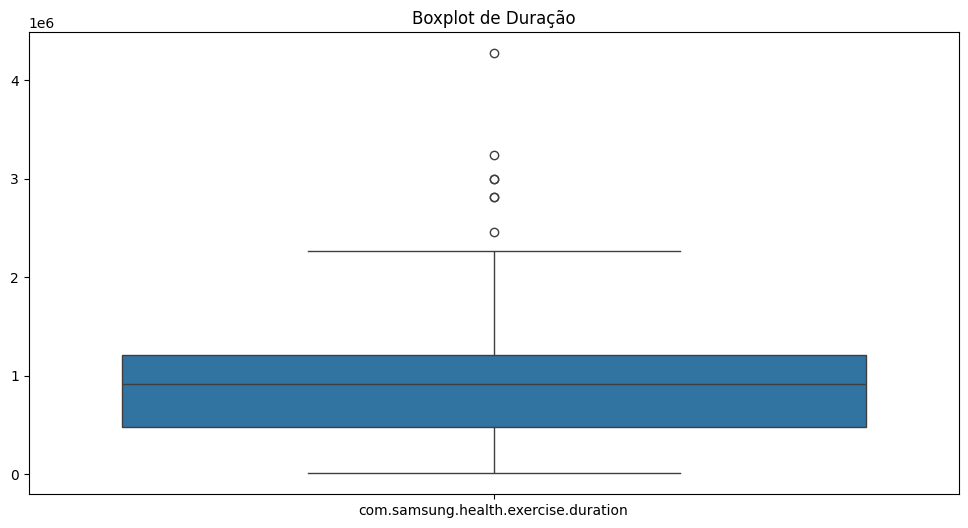

In [63]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['com.samsung.health.exercise.duration']])
plt.title("Boxplot de Duração")
plt.show()

In [64]:
Q1 = df['com.samsung.health.exercise.duration'].quantile(0.25)
Q3 = df['com.samsung.health.exercise.duration'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Limite Inferior: {limite_inferior}, Limite Superior: {limite_superior}")


Limite Inferior: -614658.375, Limite Superior: 2312798.625


In [65]:
df_sem_outliers = df_to_prepare[
    (df_to_prepare['com.samsung.health.exercise.duration'] >= limite_inferior) &
    (df_to_prepare['com.samsung.health.exercise.duration'] <= limite_superior)
]

outliers = df_to_prepare[
    (df_to_prepare['com.samsung.health.exercise.duration'] < limite_inferior) |
    (df_to_prepare['com.samsung.health.exercise.duration'] > limite_superior)
]

outliers.to_csv('outliers_removed.csv', index=False)

In [66]:

train_size = int(len(df) * 0.8)

train = df_sem_outliers.iloc[:train_size]
test = df_sem_outliers.iloc[train_size:]

X_train = train.drop(columns=['com.samsung.health.exercise.duration'])
y_train = train['com.samsung.health.exercise.duration']
X_test = test.drop(columns=['com.samsung.health.exercise.duration'])
y_test = test['com.samsung.health.exercise.duration']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(198, 8) (43, 8) (198,) (43,)


In [67]:

for col in X_train.columns:
    if not pd.api.types.is_numeric_dtype(X_train[col]):
        print(f"Coluna não numérica encontrada: {col}")



In [69]:
output_dir = "resultados_modelos_sem_outliers"
os.makedirs(output_dir, exist_ok=True)

for name, model in models.items():
    print(f"Treinando {name}...")
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R²: {r2}\n")

    output_file = os.path.join(output_dir, f"{name}_predicoes.csv")
    result_df = pd.DataFrame({
        "Valor Real": y_test,
        "Predição": y_pred,
        "Erro Absoluto": abs(y_test - y_pred)
    })
    result_df.to_csv(output_file, index=False)
    print(f"Resultados de {name} salvos em: {output_file}")
    
print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")

Treinando Gradient Boosting...
Gradient Boosting - MAE: 20716.366589787813, RMSE: 34874.31057571573, R²: 0.9909424937805555

Resultados de Gradient Boosting salvos em: resultados_modelos_sem_outliers\Gradient Boosting_predicoes.csv
Treinando SVR...
SVR - MAE: 390765.58019549935, RMSE: 444384.7615489451, R²: -0.4706715642824739

Resultados de SVR salvos em: resultados_modelos_sem_outliers\SVR_predicoes.csv
Treinando KNN...
KNN - MAE: 208999.28837209308, RMSE: 281061.7519064631, R²: 0.41169725187208495

Resultados de KNN salvos em: resultados_modelos_sem_outliers\KNN_predicoes.csv
Treinando Decision Tree...
Decision Tree - MAE: 44643.651162790695, RMSE: 86141.8965165332, R²: 0.9447380459685994

Resultados de Decision Tree salvos em: resultados_modelos_sem_outliers\Decision Tree_predicoes.csv
Treinando Random Forest...
Random Forest - MAE: 26359.498604651173, RMSE: 38965.93384438302, R²: 0.9886924749928462

Resultados de Random Forest salvos em: resultados_modelos_sem_outliers\Random Fore

# Outro teste

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Padronizar os dados para modelos sensíveis a escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste de modelos com hiperparâmetros melhores
models = {
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    "SVR": SVR(kernel='rbf', C=10, gamma=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5, weights='distance'),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}
feature_importances = {}

for name, model in models.items():
    print(f"Treinando {name}...")

    if name in ["SVR", "KNN", "Gradient Boosting"]:
        X_train_used, X_test_used = X_train_scaled, X_test_scaled
    else:
        X_train_used, X_test_used = X_train, X_test

    model.fit(X_train_used, y_train)

    y_pred = model.predict(X_test_used)

    # Corrigir previsões irreais (se o erro for maior que 30% da média dos tempos reais é feito o ajuste)
    media_real = y_test.mean()
    limite_min = media_real * 0.7  # 70% da média
    limite_max = media_real * 1.3  # 130% da média
    y_pred = np.clip(y_pred, limite_min, limite_max)

    mae = mean_absolute_error(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R²: {r2}\n")

    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_

print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")

if feature_importances:
    print("\nImportância das Features:")
    for model_name, importances in feature_importances.items():
        feature_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        print(f"\n{model_name} Feature Importances:")
        print(feature_df)


Treinando Gradient Boosting...
Gradient Boosting - MAE: 97388.02626468515, RMSE: 195854.75408636552, R²: 0.7143293552893475

Treinando SVR...
SVR - MAE: 390760.75741174887, RMSE: 444375.21874268464, R²: -0.47060840197657594

Treinando KNN...
KNN - MAE: 274022.3633032397, RMSE: 361443.880150697, R²: 0.027075520275939957

Treinando Decision Tree...
Decision Tree - MAE: 122318.9694820023, RMSE: 229757.1141411657, R²: 0.6068707892536074

Treinando Random Forest...
Random Forest - MAE: 99472.75148682961, RMSE: 196366.61157853896, R²: 0.7128342296427153

Treinando Linear Regression...
Linear Regression - MAE: 361844.3388602777, RMSE: 392950.6991477064, R²: -0.14993557783128786

Resultados Finais:
Gradient Boosting: {'MAE': 97388.02626468515, 'RMSE': np.float64(195854.75408636552), 'R²': 0.7143293552893475}
SVR: {'MAE': 390760.75741174887, 'RMSE': np.float64(444375.21874268464), 'R²': -0.47060840197657594}
KNN: {'MAE': 274022.3633032397, 'RMSE': np.float64(361443.880150697), 'R²': 0.027075520

In [72]:
""" df_sem_outliers['duration_suavizada'] = (
    df_sem_outliers['com.samsung.health.exercise.duration']
    .rolling(window=2, center=True)
    .mean()
)


# Definir o índice para dividir os dados (80% para treino)
train_size = int(len(df) * 0.8)

# Divisão sequencial
train = df_sem_outliers.iloc[:train_size]
test = df_sem_outliers.iloc[train_size:]

# Separar X e y
X_train = train.drop(columns=['com.samsung.health.exercise.duration'])
y_train = train['com.samsung.health.exercise.duration']
X_test = test.drop(columns=['com.samsung.health.exercise.duration'])
y_test = test['com.samsung.health.exercise.duration']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#print(df_sem_outliers.head(198)) """

" df_sem_outliers['duration_suavizada'] = (\n    df_sem_outliers['com.samsung.health.exercise.duration']\n    .rolling(window=2, center=True)\n    .mean()\n)\n\n\n# Definir o índice para dividir os dados (80% para treino)\ntrain_size = int(len(df) * 0.8)\n\n# Divisão sequencial\ntrain = df_sem_outliers.iloc[:train_size]\ntest = df_sem_outliers.iloc[train_size:]\n\n# Separar X e y\nX_train = train.drop(columns=['com.samsung.health.exercise.duration'])\ny_train = train['com.samsung.health.exercise.duration']\nX_test = test.drop(columns=['com.samsung.health.exercise.duration'])\ny_test = test['com.samsung.health.exercise.duration']\n\nprint(X_train.shape, X_test.shape, y_train.shape, y_test.shape)\n\n#print(df_sem_outliers.head(198)) "

In [73]:
df_sem_outliers.loc[:, 'com.samsung.health.exercise.duration'] = df_sem_outliers['com.samsung.health.exercise.duration'].clip(lower=limite_inferior, upper=limite_superior)

print(df_sem_outliers.head(198))

     com.samsung.health.exercise.distance  \
0                                 385.054   
1                                   1.812   
2                                 357.093   
3                                  99.515   
4                                1554.750   
..                                    ...   
196                                 3.141   
197                                 3.572   
198                                 3.572   
199                                 3.239   
200                               282.828   

     com.samsung.health.exercise.mean_speed  \
0                                     2.094   
1                                     2.533   
2                                    19.065   
3                                    20.397   
4                                    25.346   
..                                      ...   
196                                  29.568   
197                                  29.571   
198                                 

In [74]:
import joblib

# Diretório para salvar os modelos
model_filenames = {
    "Gradient Boosting": "gradient_boosting_sem_caloria.pkl",
    "SVR": "svr_sem_caloria.pkl",
    "KNN": "knn_sem_caloria.pkl",
    "Decision Tree": "decision_tree_sem_caloria.pkl",
    "Random Forest": "random_forest_sem_caloria.pkl",
    "Linear Regression": "linear_regression_sem_caloria.pkl"
}

for name, model in models.items():
    filename = model_filenames[name]
    joblib.dump(model, filename)
    print(f"Modelo {name} salvo como {filename}")


Modelo Gradient Boosting salvo como gradient_boosting_sem_caloria.pkl
Modelo SVR salvo como svr_sem_caloria.pkl
Modelo KNN salvo como knn_sem_caloria.pkl
Modelo Decision Tree salvo como decision_tree_sem_caloria.pkl
Modelo Random Forest salvo como random_forest_sem_caloria.pkl
Modelo Linear Regression salvo como linear_regression_sem_caloria.pkl


In [ ]:
import joblib
import pandas as pd

model_filenames = {
    "Gradient Boosting": "gradient_boosting_sem_caloria.pkl",
    "SVR": "svr_sem_caloria.pkl",
    "KNN": "knn_sem_caloria.pkl",
    "Decision Tree": "decision_tree_sem_caloria.pkl",
    "Random Forest": "random_forest_sem_caloria.pkl",
    "Linear Regression": "linear_regression_sem_caloria.pkl"
}

# Carrega os modelos
try:
    models = {name: joblib.load(filename) for name, filename in model_filenames.items()}
except FileNotFoundError as e:
    print(f"Erro ao carregar modelos: {e}")
    exit()

# Carrega os dados de teste
try:
    X_test = pd.read_csv("dados_de_teste.csv")  # Ajuste o caminho se necessário
except FileNotFoundError:
    print("Arquivo 'dados_de_teste.csv' não encontrado.")
    exit()

if X_test.empty:
    print("O arquivo 'dados_de_teste.csv' está vazio.")
    exit()

# Extrai a última linha dos dados de teste
ultima_linha = X_test.iloc[-1].to_dict()

# Função para fazer a previsão
def prever_duracao(model, distancia):
    dados = ultima_linha.copy()
    
    # Converte a distância para o mesmo tipo de dado presente no dataset
    try:
        distancia = type(dados['com.samsung.health.exercise.distance'])(distancia)
    except KeyError:
        print("Coluna 'com.samsung.health.exercise.distance' não encontrada no dataset.")
        return None, None
    
    dados['com.samsung.health.exercise.distance'] = distancia
        
    df = pd.DataFrame([dados])

    try:
        duracao_ms = model.predict(df)[0]  # Retorna a duração prevista em milissegundos
    except Exception as e:
        print(f"Erro ao fazer previsão com o modelo: {e}")
        return None, None

    # Converte milissegundos para minutos e segundos
    duracao_segundos = duracao_ms / 1000
    minutos = int(duracao_segundos // 60)
    segundos = int(duracao_segundos % 60)

    return minutos, segundos

distancia = input("Digite a distância em metros: ")

try:
    distancia = float(distancia)
except ValueError:
    print("Entrada inválida para distância. Digite um número válido.")
    exit()

# Roda todos os modelos e exibir previsões
print("\nResultados das previsões:")
for name, model in models.items():
    minutos, segundos = prever_duracao(model, distancia)
    if minutos is not None and segundos is not None:
        print(f"{name}: {minutos} minutos e {segundos} segundos.")

                                             com.samsung.health.exercise.distance  \
com.samsung.health.exercise.distance                                     1.000000   
com.samsung.health.exercise.mean_speed                                   0.041552   
com.samsung.health.exercise.duration                                     0.745632   
com.samsung.health.exercise.mean_heart_rate                              0.340970   
sleep_duration                                                          -0.220974   
temperature_2m                                                          -0.065672   
relative_humidity_2m                                                    -0.010087   
sleep_score                                                             -0.045228   
mental_recovery                                                          0.100769   

                                             com.samsung.health.exercise.mean_speed  \
com.samsung.health.exercise.distance                          

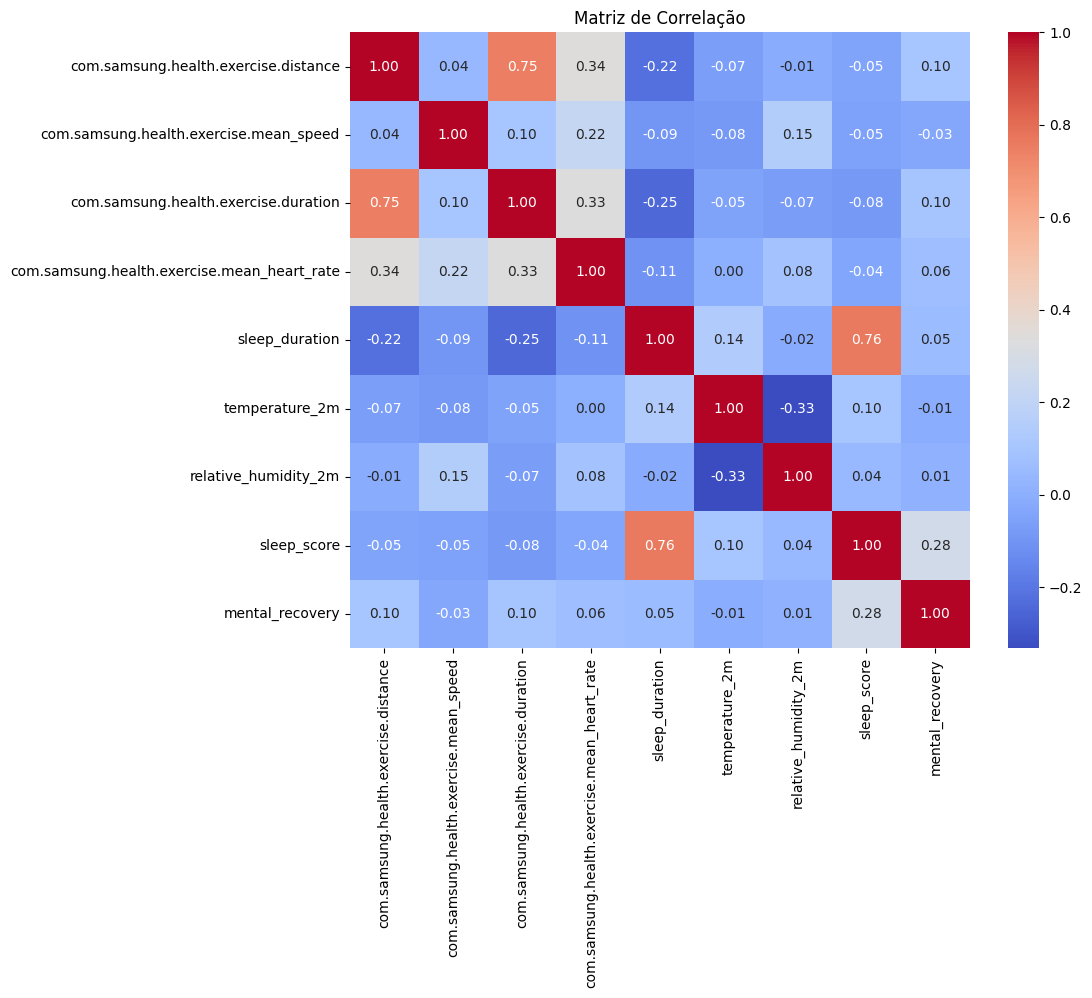

In [ ]:
correlation_matrix = df_to_prepare.corr()

# Exibir a matriz de correlação
print(correlation_matrix)

# Plotar como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()